### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### Data Cleaning

In [4]:
df = pd.read_csv("honda_car_selling.csv")
df.head()

,Year,kms Driven,Fuel Type,Suspension,Price,Car Model
0,2019,19006 kms,Petrol,Automatic,9.29 Lakh,Honda City V CVT
1,2021,11936 kms,Petrol,Automatic,13.95 Lakh,Honda City ZX CVT
2,2018,29635 kms,Petrol,Automatic,9.95 Lakh,Honda City i-VTEC CVT ZX
3,2020,16163 kms,Petrol,Automatic,13.26 Lakh,Honda City ZX CVT
4,2015,105114 kms,Petrol,Manual,5.68 Lakh,Honda City i VTEC V


In [5]:
print("Shape:", df.shape)

Shape: (999, 6)


In [6]:
df.info()
display(df.describe(include='all').T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year        999 non-null    int64 
 1   kms Driven  999 non-null    object
 2   Fuel Type   999 non-null    object
 3   Suspension  999 non-null    object
 4   Price       999 non-null    object
 5   Car Model   999 non-null    object
dtypes: int64(1), object(5)
memory usage: 47.0+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Year,999.0,NaN,NaN,NaN,2014.717718,3.713756,2000.0,2013.0,2015.0,2017.0,2023.0
kms Driven,999,693,70000 kms,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fuel Type,999,3,Petrol,797,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Suspension,999,2,Manual,776,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,999,332,3 Lakh,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Car Model,999,183,Honda City 1.5 S MT,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print("\nMissing values per column:")
print(df.isnull().sum())

before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"\nDropped {before-after} duplicate rows.")


Missing values per column:
Year          0
kms Driven    0
Fuel Type     0
Suspension    0
Price         0
Car Model     0
dtype: int64

Dropped 25 duplicate rows.


In [8]:
df.columns = [c.strip().replace(' ', '_').replace('-', '_') for c in df.columns]
df.columns

Index(['Year', 'kms_Driven', 'Fuel_Type', 'Suspension', 'Price', 'Car_Model'], dtype='object')

### Feature engineering(Age from Year, clean kms & Price)

In [10]:
kms_col = None
for c in df.columns:
    if c.lower().startswith('kms') or 'kms' in c.lower():
        kms_col = c
        break
print("kms column detected:", kms_col)

# Clean kms: keep digits only and convert to int
df[kms_col] = df[kms_col].astype(str).str.replace(',', '').str.strip().str.split().str.get(0)
df = df[df[kms_col].str.replace('.', '', 1).str.isnumeric()]  # drop clearly bad rows
df[kms_col] = df[kms_col].astype(int)

# Clean Price (target)
price_col = None
for c in df.columns:
    if c.lower() == 'price' or 'price' in c.lower():
        price_col = c
        break
print("price column detected:", price_col)
df[price_col] = df[price_col].astype(str).str.replace(',', '').str.strip()
df = df[df[price_col].str.replace('.', '', 1).str.isnumeric()]
df[price_col] = df[price_col].astype(float)

# Age from Year (choose reference year 2025)
if 'Year' in df.columns:
    df['Age'] = 2025 - df['Year'].astype(int)
    df = df.drop(columns=['Year'])

# Quick head
df[[kms_col, price_col, 'Age']].head()


kms column detected: kms_Driven
price column detected: Price


,kms_Driven,Price,Age
588,149714,45000.0,22
594,39460,80000.0,17
802,120000,85000.0,18
828,110000,60000.0,20
939,92000,95000.0,17


### Outlier detection & handling (IQR method)

In [12]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove(price_col)  # exclude target

def remove_outliers_iqr(df_, col):
    Q1 = df_[col].quantile(0.25)
    Q3 = df_[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    before = df_.shape[0]
    df_clean = df_[(df_[col] >= lower) & (df_[col] <= upper)]
    after = df_clean.shape[0]
    print(f"Removed {before-after} outliers from {col}")
    return df_clean

# Option: remove outliers for kms and Age 
for c in ['kms_Driven','kms_Driven'.replace('_',' ')]:
    pass  # placeholder

# Apply to a few numeric columns we care about
for c in [kms_col, 'Age']:
    if c in df.columns:
        df = remove_outliers_iqr(df, c)

print("Shape after outlier removal:", df.shape)


Removed 0 outliers from kms_Driven
Removed 0 outliers from Age
Shape after outlier removal: (6, 6)


### EDA (distributions, correlations, categorical counts)

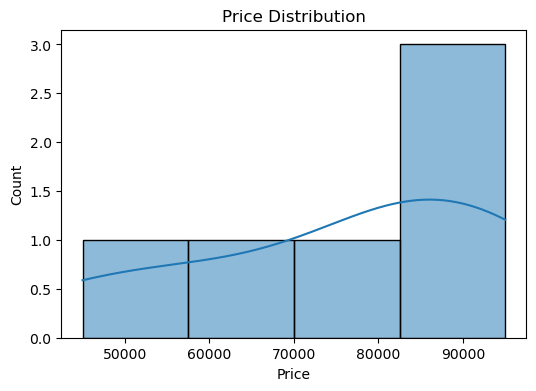

In [14]:
# Price distribution
plt.figure(figsize=(6,4))
sns.histplot(df[price_col], kde=True)
plt.title("Price Distribution")
plt.show()


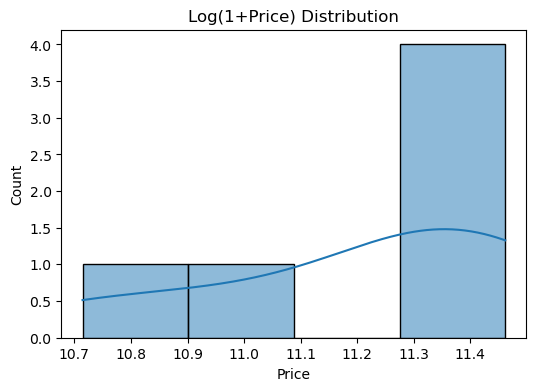

In [15]:
# Log Price if skewed
plt.figure(figsize=(6,4))
sns.histplot(np.log1p(df[price_col]), kde=True)
plt.title("Log(1+Price) Distribution")
plt.show()

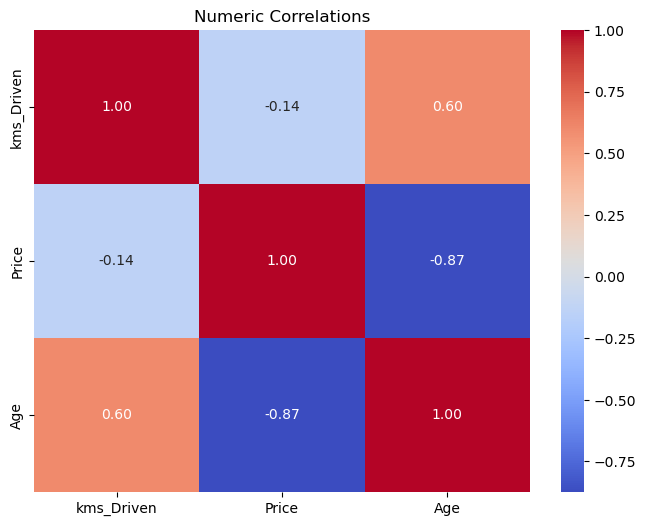

In [16]:
# Numeric pairwise correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Numeric Correlations")
plt.show()


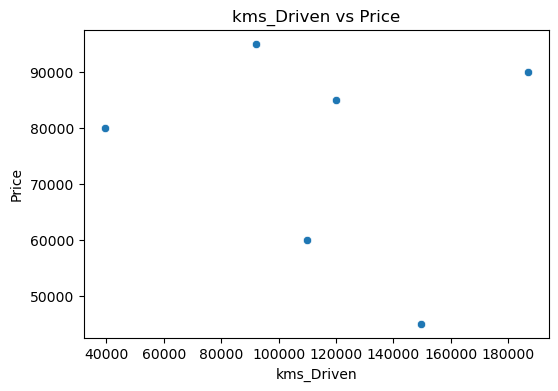

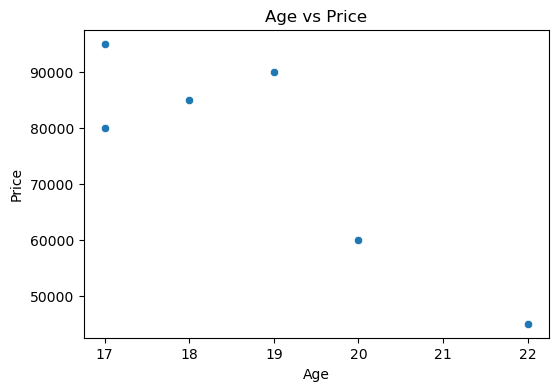

In [17]:
# Scatter plots for kms and Age vs Price
if kms_col in df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[kms_col], y=df[price_col])
    plt.title(f"{kms_col} vs {price_col}")
    plt.show()

if 'Age' in df.columns:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df['Age'], y=df[price_col])
    plt.title("Age vs Price")
    plt.show()

In [18]:
# Categorical columns exploration (top categories)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in cat_cols:
    print("\nColumn:", c)
    display(df[c].value_counts().head(10))


Column: Fuel_Type


Fuel_Type
Petrol     6
Name: count, dtype: int64


Column: Suspension


Suspension
Manual    6
Name: count, dtype: int64


Column: Car_Model


Car_Model
Honda City 1.5 GXI      2
Honda City GXi          2
Honda Civic 1.8 S MT    1
Honda City VTEC         1
Name: count, dtype: int64

### Feature engineering (transformations & new features)

In [20]:
# 1) Log transform kms
if kms_col in df.columns:
    df['log_kms'] = np.log1p(df[kms_col])

# 2) If Fuel_Type or Transmission present, keep them; else list possible categorical features
print("Categorical columns:", cat_cols)

# 3) Create binary indicator for high mileage 
if kms_col in df.columns:
    df['high_mileage'] = (df[kms_col] > df[kms_col].median()).astype(int)


Categorical columns: ['Fuel_Type', 'Suspension', 'Car_Model']


### Prepare dataset for modeling (encoding + split)

In [22]:
# Choose features to keep
features = []
# numeric features
for f in ['Age', 'log_kms', kms_col, 'high_mileage']:
    if f in df.columns:
        features.append(f)

# add categorical features (take up to N small-cardinality ones)
for c in cat_cols:
    # skip free-text columns if huge cardinality; keep columns with <= 20 unique values
    if df[c].nunique() <= 30:
        features.append(c)

print("Using features:", features)

X = df[features].copy()
y = df[price_col].copy()

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, "Test:", X_test.shape)


Using features: ['Age', 'log_kms', 'kms_Driven', 'high_mileage', 'Fuel_Type', 'Suspension', 'Car_Model']
Train: (4, 7) Test: (2, 7)


### Build preprocessing pipelines

In [24]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


### Models to evaluate

In [26]:
models = {
    "LinearRegression": Pipeline([('preproc', preprocessor), ('model', LinearRegression())]),
    "Ridge": Pipeline([('preproc', preprocessor), ('model', Ridge(random_state=42))]),
    "Lasso": Pipeline([('preproc', preprocessor), ('model', Lasso(random_state=42))]),
    "RandomForest": Pipeline([('preproc', preprocessor), ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))]),
    "HistGradientBoosting": Pipeline([('preproc', preprocessor), ('model', HistGradientBoostingRegressor(random_state=42))])
}

### Evaluation function & cross-validation

In [28]:
def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

def evaluate_model_cv(pipe, X, y, cv=5):
    # return mean RMSE and mean R2 across folds
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    neg_mse = cross_val_score(pipe, X, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    rmse_scores = np.sqrt(-neg_mse)
    r2_scores = cross_val_score(pipe, X, y, scoring='r2', cv=kf, n_jobs=-1)
    return {"CV_RMSE_mean": rmse_scores.mean(), "CV_RMSE_std": rmse_scores.std(), "CV_R2_mean": r2_scores.mean(), "CV_R2_std": r2_scores.std()}


### Train, evaluate & compare models (train on train set, evaluate on test)

In [30]:
results = []
cv_results = {}

for name, pipe in models.items():
    print(f"\nTraining {name} ...")
    pipe.fit(X_train, y_train)
    # test metrics
    pred_test = pipe.predict(X_test)
    metrics = get_metrics(y_test, pred_test)
    results.append([name, metrics['MAE'], metrics['MSE'], metrics['RMSE'], metrics['R2']])
    # cv metrics (on full X,y for more stable estimate)
    cvres = evaluate_model_cv(pipe, X, y, cv=5)
    cv_results[name] = cvres
    print(f"{name} Test RMSE: {metrics['RMSE']:.2f}, R2: {metrics['R2']:.4f}")
    print(f"{name} CV RMSE (mean ± std): {cvres['CV_RMSE_mean']:.2f} ± {cvres['CV_RMSE_std']:.2f}")



Training LinearRegression ...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


LinearRegression Test RMSE: 3398.91, R2: 0.9623
LinearRegression CV RMSE (mean ± std): 4498.68 ± 1960.76

Training Ridge ...
Ridge Test RMSE: 7957.63, R2: 0.7932
Ridge CV RMSE (mean ± std): 7097.96 ± 3562.44

Training Lasso ...
Lasso Test RMSE: 5702.33, R2: 0.8938
Lasso CV RMSE (mean ± std): 4320.50 ± 1599.65

Training RandomForest ...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  war

RandomForest Test RMSE: 21016.50, R2: -0.4423
RandomForest CV RMSE (mean ± std): 14733.85 ± 5828.66

Training HistGradientBoosting ...
HistGradientBoosting Test RMSE: 26575.36, R2: -1.3061
HistGradientBoosting CV RMSE (mean ± std): 19315.07 ± 5308.29


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


### Results table & ordering

In [32]:
results_df = pd.DataFrame(results, columns=["Model", "MAE", "MSE", "RMSE", "R2"])
results_df = results_df.sort_values(by="RMSE").reset_index(drop=True)
results_df

,Model,MAE,MSE,RMSE,R2
0,LinearRegression,3044.958378,1.155257e+07,3398.906476,0.962277
1,Lasso,4647.675413,3.251656e+07,5702.329245,0.893823
2,Ridge,6540.445052,6.332391e+07,7957.632438,0.793228
3,RandomForest,17425.000000,4.416931e+08,21016.496497,-0.442263
4,HistGradientBoosting,20000.000000,7.062500e+08,26575.364532,-1.306122


### Residual plots for the best model

Best model: LinearRegression


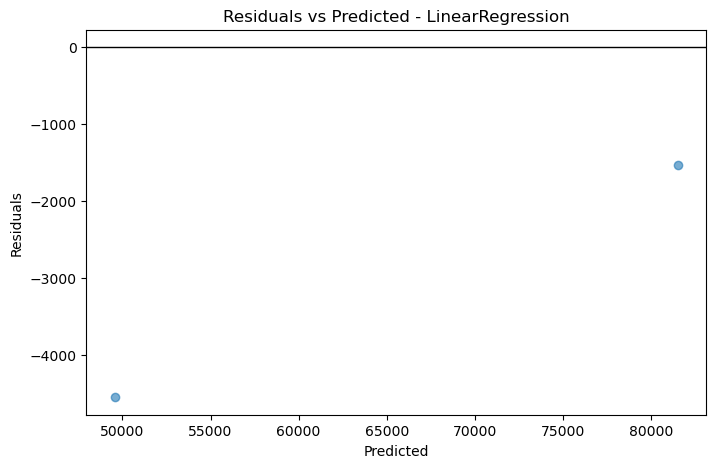

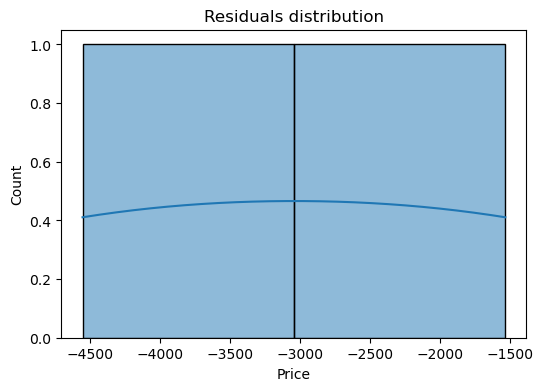

In [34]:
best_model_name = results_df.loc[0, "Model"]
best_pipeline = models[best_model_name]
print("Best model:", best_model_name)

y_pred_best = best_pipeline.predict(X_test)
residuals = y_test - y_pred_best

plt.figure(figsize=(8,5))
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title(f"Residuals vs Predicted - {best_model_name}")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residuals distribution")
plt.show()


### Feature importance / coefficients

,feature,coef
0,Age,-9824.919859
7,Car_Model_Honda City GXi,6013.421699
6,Car_Model_Honda City 1.5 GXI,-4637.464267
2,kms_Driven,2284.951553
3,high_mileage,1551.841029
8,Car_Model_Honda City VTEC,-1375.957433
1,log_kms,1261.980707
4,Fuel_Type_ Petrol,0.000000
5,Suspension_ Manual,0.000000


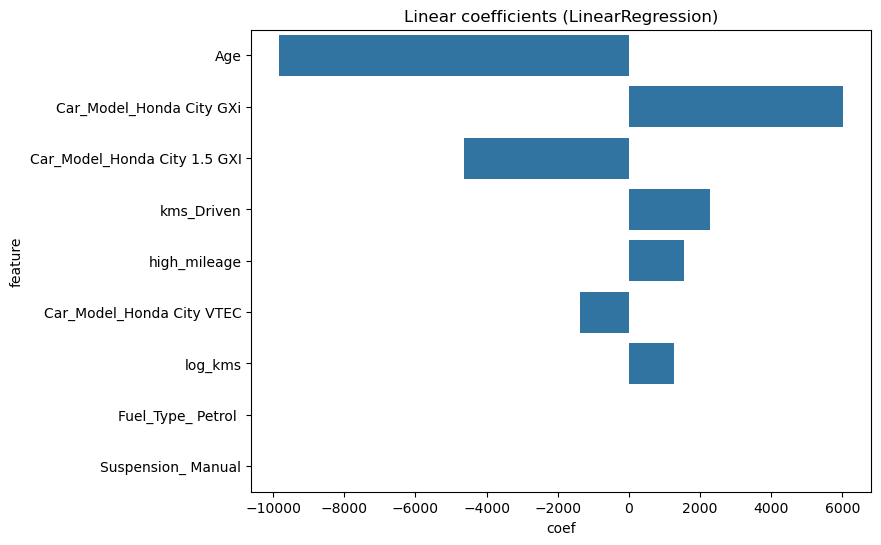

In [36]:
# Get feature names after preprocessing
preproc = best_pipeline.named_steps['preproc']
# numeric feature names
num_feats = numeric_features
cat_feats = categorical_features

# Build full feature names (onehot output)
ohe = None
if cat_feats:
    ohe = preproc.named_transformers_['cat'].named_steps['onehot']
    cat_names = list(ohe.get_feature_names_out(cat_feats))
else:
    cat_names = []

feat_names = num_feats + cat_names

model_obj = best_pipeline.named_steps['model']

if hasattr(model_obj, "feature_importances_"):
    importances = model_obj.feature_importances_
    fi = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values("importance", ascending=False)
    display(fi.head(20))
    # Plot
    plt.figure(figsize=(8,6))
    sns.barplot(x="importance", y="feature", data=fi.head(15))
    plt.title(f"Feature importances ({best_model_name})")
    plt.show()
elif hasattr(model_obj, "coef_"):
    coefs = model_obj.coef_
    coef_df = pd.DataFrame({"feature": feat_names, "coef": coefs}).sort_values("coef", key=lambda s: s.abs(), ascending=False)
    display(coef_df.head(20))
    plt.figure(figsize=(8,6))
    sns.barplot(x="coef", y="feature", data=coef_df.head(15))
    plt.title(f"Linear coefficients ({best_model_name})")
    plt.show()
else:
    print("Model does not expose feature importances or coefficients.")


### Save best model

In [38]:
final_best = models[results_df.loc[0, "Model"]]
joblib.dump(final_best, "best_model_pipeline.pkl")
print("Saved:", "best_model_pipeline.pkl")


Saved: best_model_pipeline.pkl
